# Repeat quasars

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table, unique

 ### Use `bossquery` from the bossdata package to get data:
 #### http://bossdata.readthedocs.org/en/latest/scripts.html#bossquery

##### BOSS  (export BOSS_REDUX_VERSION=v5_7_0)
##### DR13  (export BOSS_REDUX_VERSION=v5_9_0)
##### eBOSS (export BOSS_REDUX_VERSION=v5_9_1)
##### DR14 (export BOSS_REDUX_VERSION=v5_10_0)

#### Selection criteria: `OBJTYPE=QSO`

`bossquery --full --what 'PLATE,MJD,FIBER,THING_ID,RUN,RERUN,CAMCOL,FIELD,ID,PLUG_RA,PLUG_DEC,SPECTROFLUX_1,SPECTROFLUX_2,SPECTROFLUX_3' --where 'OBJTYPE="QSO"' --max-rows 900000 --save 'data_release'_target_qsos.dat`


In [3]:
dr14 = Table.read('data/dr14_target_qsos.dat', format='ascii')
eboss = Table.read('data/eboss_target_qsos.dat', format='ascii')
dr13 = Table.read('data/dr13_target_qsos.dat', format='ascii')
boss = Table.read('data/boss_target_qsos.dat', format='ascii')

In [4]:
print 'BOSS returned {} quasars'.format(len(boss))
print 'DR13 returned {} quasars'.format(len(dr13))
print 'eBOSS returned {} quasars'.format(len(eboss))
print 'DR14 returned {} quasars'.format(len(dr14))

BOSS returned 465264 quasars
DR13 returned 466097 quasars
eBOSS returned 121131 quasars
DR14 returned 650188 quasars


#### Chronology of Data Releases

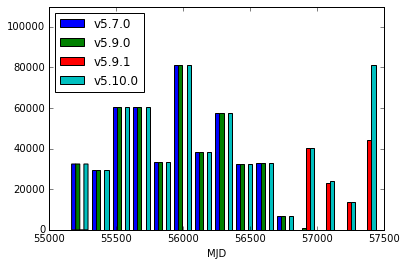

In [5]:
plt.hist((boss['MJD'], dr13['MJD'], eboss['MJD'], dr14['MJD']), bins=15, range=[55150, 57450])
plt.legend(('v5.7.0','v5.9.0','v5.9.1','v5.10.0'),loc=2)
plt.xlabel('MJD')
plt.ylim(0,110000);

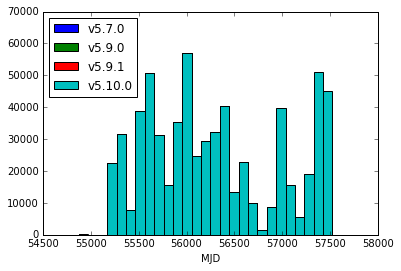

In [6]:
mjd_range = [min(boss['MJD'])-300, max(dr14['MJD'])+300]
bins = 30
plt.hist(boss['MJD'], bins=bins, range=mjd_range)
plt.hist(dr13['MJD'], bins=bins, range=mjd_range)
plt.hist(eboss['MJD'], bins=bins, range=mjd_range)
plt.hist(dr14['MJD'], bins=bins, range=mjd_range)
plt.legend(('v5.7.0','v5.9.0','v5.9.1','v5.10.0'), loc=2)
plt.xlabel('MJD')
plt.ylim(0,70000);

## Matching

In [7]:
dr14_grouped = dr14.group_by(['THING_ID', 'MJD'])
mask = dr14_grouped['THING_ID'] != -1
dr14_masked = dr14_grouped[mask]

In [8]:
def unique_counts(data):
    data_ids = np.asarray(data['THING_ID'])
    return np.unique(data_ids, return_index=True, return_counts=True)

def find_repeat_indices(data):
    unique, index, counts = unique_counts(data)
    unique, index, counts = unique[counts>1], index[counts>1], counts[counts>1]
    all_instances = []
    for i in range(len(unique)):
        for j in range(counts[i]):
            all_instances.append(index[i]+j)
    return all_instances

In [9]:
all_instances = find_repeat_indices(dr14_masked)
repeat_qsos = dr14_masked[all_instances]
#repeat_qsos.write('data/repeats.dat', format='ascii')

### Verify that imaging fields match:

In [19]:
def check_imaging_fields(data, field):
    unique, index, counts = unique_counts(data)
    unique, index, counts = unique[counts>1], index[counts>1], counts[counts>1]
    for i in range(len(unique)):
        for j in range(counts[i]-1):
            if data[field][index[i]+j] != data[field][index[i]+j+1]:
                print 'Error'
                break
    print('Fields match.')

In [20]:
check_imaging_fields(dr14_masked, 'RUN')

Fields match.


In [21]:
check_imaging_fields(dr14_masked, 'RERUN')

Fields match.


In [22]:
check_imaging_fields(dr14_masked, 'CAMCOL')

Fields match.


In [23]:
check_imaging_fields(dr14_masked, 'FIELD')

Fields match.


In [24]:
check_imaging_fields(dr14_masked, 'ID')

Fields match.


## Plots

In [25]:
def get_pairs(data):
    unique, index, counts = unique_counts(data)
    unique, index, counts = unique[counts>1], index[counts>1], counts[counts>1]
    pairs = []
    for i in range(len(unique)):
        for j in range(counts[i]-1):
            pairs.append((index[i]+j, index[i]+j+1))
    return pairs

def get_pair_data(pairs, data, field):
    initial = []
    repeat = []
    for i in range(len(pairs)):
        initial.append(data[field][pairs[i][0]])
        repeat.append(data[field][pairs[i][1]])
    return np.asarray(initial), np.asarray(repeat)

def plot_statistics(x, y, num_bins, xmax, title=None, save=None):
    good_vals = np.isfinite(y)
    y = y[good_vals]
    x = x[good_vals]
    in_window = (y > np.percentile(y, 1))&(y < np.percentile(y, 99))
    y = y[in_window]
    x = x[in_window]
    y_mean = np.mean(y)
    percentile_edges = np.linspace(0, 100, num_bins+1)
    bin_edges = np.percentile(x, percentile_edges)
    zero_order = np.histogram(x, bins=bin_edges)[0]
    first_order = np.histogram(x, bins=bin_edges, weights=y)[0]
    second_order = np.histogram(x, bins=bin_edges, weights=y**2)[0]
    mean = first_order/zero_order
    std_dev = np.sqrt(second_order/zero_order - mean**2)
    mean_err = std_dev/np.sqrt(zero_order)
    std_dev_err = std_dev/np.sqrt(2*(zero_order-1))
    x_axis = np.empty(num_bins)
    for i in range(num_bins):
        select = (x>=bin_edges[i])&(x<bin_edges[i+1])
        x_axis[i] = np.mean(x[select])
    plt.figure(figsize=(13,6))
    plt.subplot(1,2,1)
    #plt.scatter(x, y, lw=0, color='r', alpha=0.1)
    plt.xlim(-10, xmax)
    plt.ylim(-.06, .06)
    plt.errorbar(x_axis, mean, ls='None', color='b', lw=1.5, yerr=mean_err)
    plt.xlabel('$\Delta MJD$', fontsize=16)
    plt.ylabel('$Mean\,(m_{n+1} - m_{n})$', fontsize=16)
    plt.grid()
    plt.subplot(1,2,2)
    plt.scatter(x_axis, std_dev, lw=0, color='r', alpha=0.5)
    plt.errorbar(x_axis, std_dev, ls='None', color='g', lw=1.5, yerr=std_dev_err)
    plt.xlim(-10, xmax)
    plt.xlabel('$\Delta MJD$', fontsize=16)
    plt.ylabel('$Std\,Dev\,(m_{n+1} - m_{n})$', fontsize=16)
    plt.grid()
    if title:
        plt.suptitle(title, fontsize=16)
    if save:
        plt.savefig(save)

In [26]:
p = get_pairs(dr14_masked)
initial, repeat = get_pair_data(p, dr14_masked, 'MJD')
gband_init, gband_rep = get_pair_data(p, dr14_masked, 'SPECTROFLUX_1')
rband_init, rband_rep = get_pair_data(p, dr14_masked, 'SPECTROFLUX_2')
iband_init, iband_rep = get_pair_data(p, dr14_masked, 'SPECTROFLUX_3')

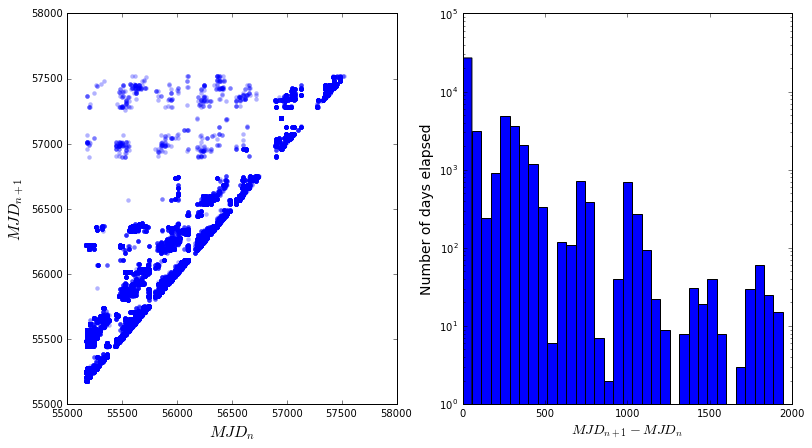

In [27]:
fig = plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
plt.scatter(initial, repeat, lw=0, alpha=0.3)
plt.xlabel('$MJD_{n}$', fontsize=16)
plt.ylabel('$MJD_{n+1}$', fontsize=16)
plt.subplot(1,2,2)
plt.hist(repeat-initial, bins=35, range=(0,2000))
plt.yscale('log')
plt.xlabel('$MJD_{n+1}-MJD_{n}$', fontsize=14)
plt.ylabel('Number of days elapsed', fontsize=14)
plt.savefig('figures/days.png');

Relative magnitude vs elapsed time between pairs of repeat quasar observations in three passbands. For example, if a quasar was observed three times it would show up in the plots as two pairs: the first and second and the second and third. The data in each band are binned and their mean and standard deviation are calculated and plotted along with their respective errors.

##### g-band

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


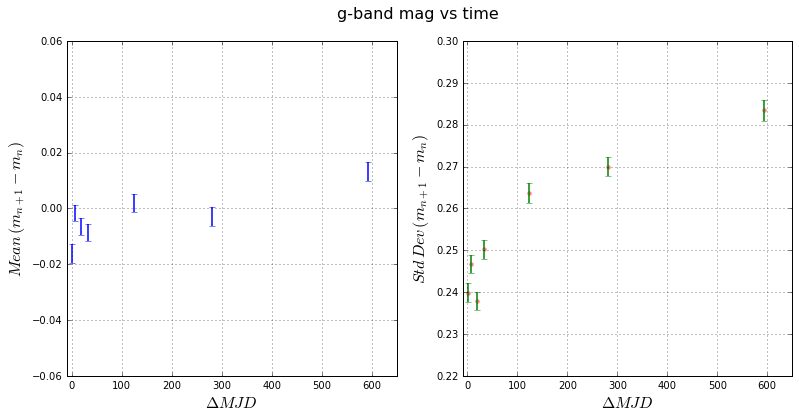

In [31]:
plot_statistics(repeat-initial, 
                -2.5*np.log10(gband_rep/gband_init), num_bins=7, xmax=650, 
                title='g-band mag vs time', save='figures/g_band.png');

##### r-band

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


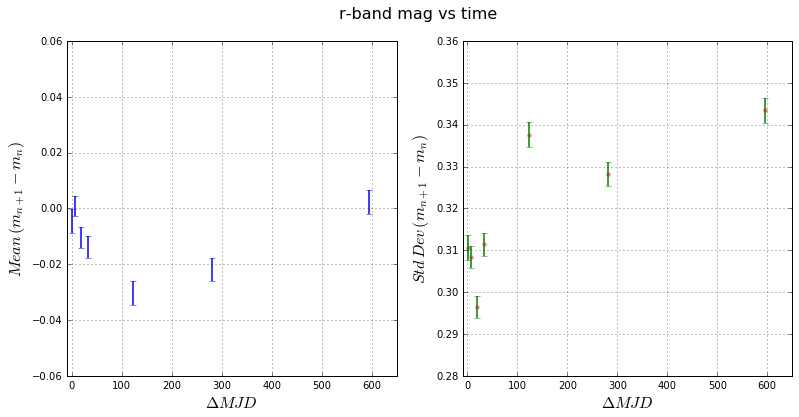

In [32]:
plot_statistics(repeat-initial, 
                -2.5*np.log10(rband_rep/rband_init), num_bins=7, xmax=650,
                 title='r-band mag vs time', save='figures/r_band.png');

##### i-band

/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/belaabolfathi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


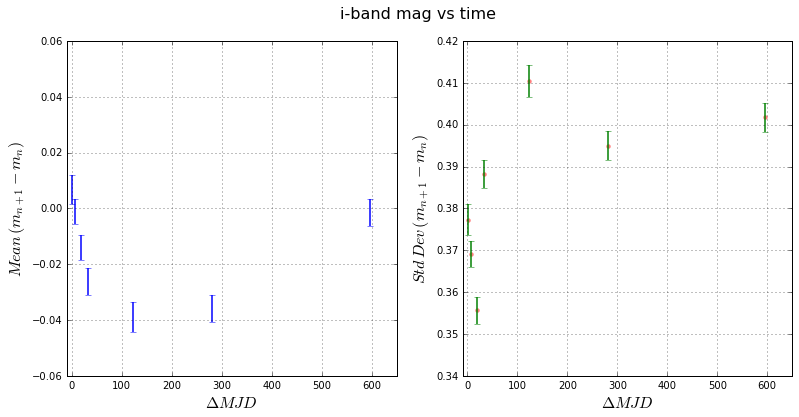

In [33]:
plot_statistics(repeat-initial, 
                -2.5*np.log10(iband_rep/iband_init), num_bins=7, xmax=650,
                 title='i-band mag vs time', save='figures/i_band.png');